In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psrchive as psr
import os
import pandas as pd
import seaborn as sns
import sys
%matplotlib notebook
from scipy import stats
import bilby

In [2]:
telescope='MeerKAT'

In this notebook analysis of pulse shape variations or pulse phase jitter will be done

To do that a residual profile for each observation will be computed. The observed profile will be subtracted from the template of the pulsar. 

But to do this the 2D template obtained from the PulsePortraiture should be shifted and scaled to fit the observation

Aligning the template with the observation

In [3]:
ar_port=psr.Archive_load("/fred/oz005/users/akulkarn/J0437-4715/templates/DRTemplate/J0437-4715-Lband_wb_template_f32.port")
ar_port.fscrunch()

ar_avgprof=psr.Archive_load("/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/Frequency_Appended_all_withK/Corrected_DM/Integrated_8sec/Entire_observation_avgProf.ar")
ar_avgprof.set_dispersion_measure(2.64160768625521)
ar_avgprof.dedisperse()
ar_avgprof.pscrunch()
ar_avgprof.fscrunch()


avg_prof=ar_avgprof.get_data()[0,0,0]
port=ar_port.get_data()[0,0,0]

cross_corr=np.correlate(avg_prof,port,"full")
ph_r=(np.nanargmax(cross_corr)-port.shape[0])/port.shape[0]

######  Fitting Template/Portrait with Observation.

In [4]:
ar_port=psr.Archive_load("/fred/oz005/users/akulkarn/J0437-4715/templates/DRTemplate/J0437-4715-Lband_wb_template_f32.port")

ar_port.centre_max_bin()
port=ar_port.get_data()[0,0]

In [5]:
ar_avgprof=psr.Archive_load("/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/Frequency_Appended_all_withK/Corrected_DM/Integrated_8sec/Entire_observation_avgProf.ar")

ar_avgprof.set_dispersion_measure(2.64160768625521) ## MeerKAT
ar_avgprof.rotate_phase(ph_r-0.002)   ## It was observed that the phase is offset by 0.002 
ar_avgprof.dedisperse()
ar_avgprof.pscrunch()
ar_avgprof.remove_baseline()

weights=ar_avgprof.get_weights()
avg_prof=ar_avgprof.get_data()[0,0]

In [6]:
def template_calib(x,mul,chn):
    return(port[int(chn),x]*mul)

sigma=np.std(avg_prof[:,0:100],axis=1)

calib=[]
for i in np.arange(0,avg_prof.shape[0]):
    likelihood = bilby.likelihood.GaussianLikelihood(np.arange(0,avg_prof.shape[1]), avg_prof[i], template_calib, float(sigma[i]*10))

    priors=dict()
    priors["mul"] = bilby.core.prior.Uniform(0, 10000, "mul")
    priors["chn"]= int(i)

    outdir=outdir = "/home/akulkarn/notebooks/bibly_results_Template_calib/Chn_"+str(i)

    result = bilby.run_sampler(
            likelihood=likelihood,
            priors=priors,
            sampler="dynesty",
            nlive=250,
            outdir=outdir,
            clean=True
        )
    result.plot_corner()

    calib.append(result.get_one_dimensional_median_and_error_bar("mul").median)
    

<IPython.core.display.Javascript object>


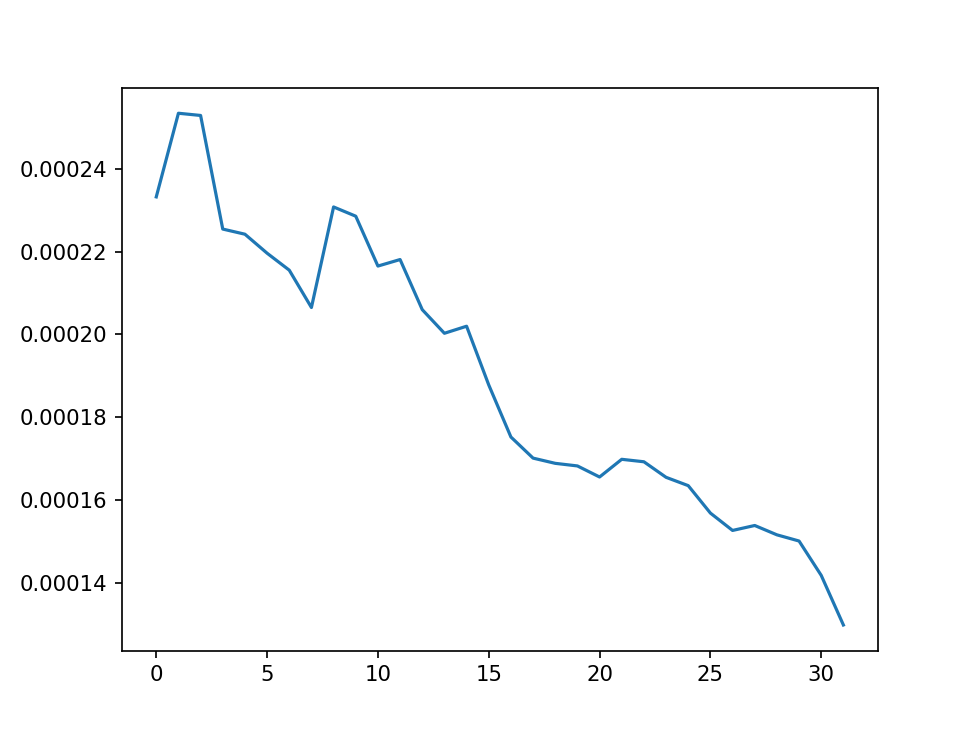

In [7]:
calib=np.loadtxt("/home/akulkarn/notebooks/mk_template_calib.txt")
plt.figure()
plt.plot(calib)
#np.savetxt("mk_template_calib.txt",calib)

<IPython.core.display.Javascript object>


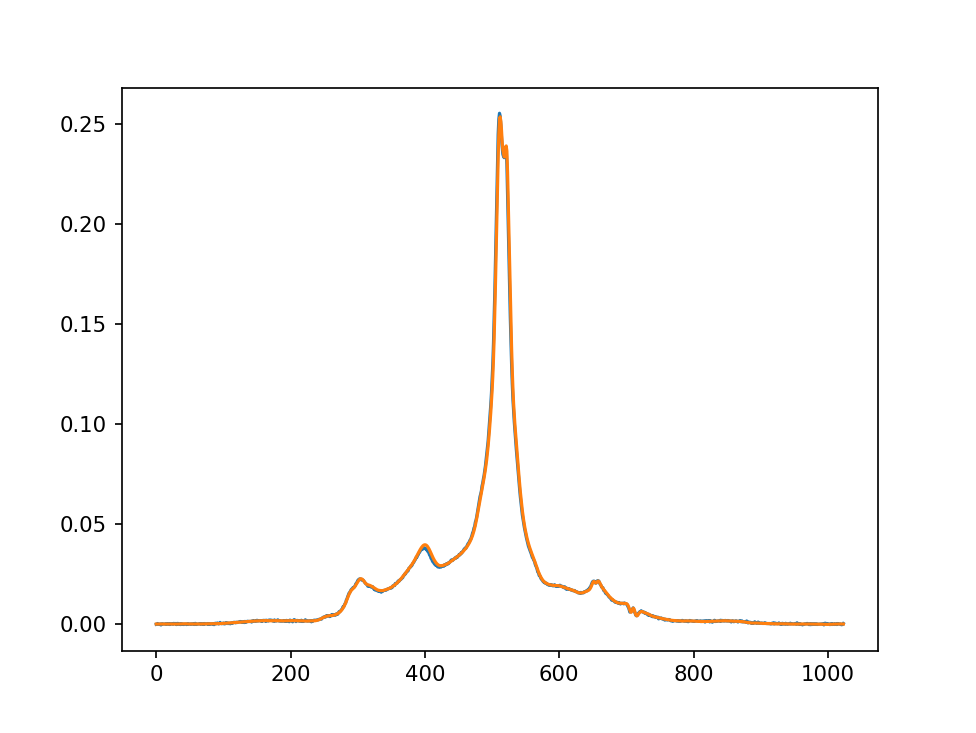

In [8]:
plt.figure()
plt.plot(np.arange(0,avg_prof.shape[1]),(avg_prof[10]))
plt.plot(template_calib(np.arange(0,avg_prof.shape[1]),calib[10],10))

Scaling and plotting the portrait according to calibration fits.

<IPython.core.display.Javascript object>


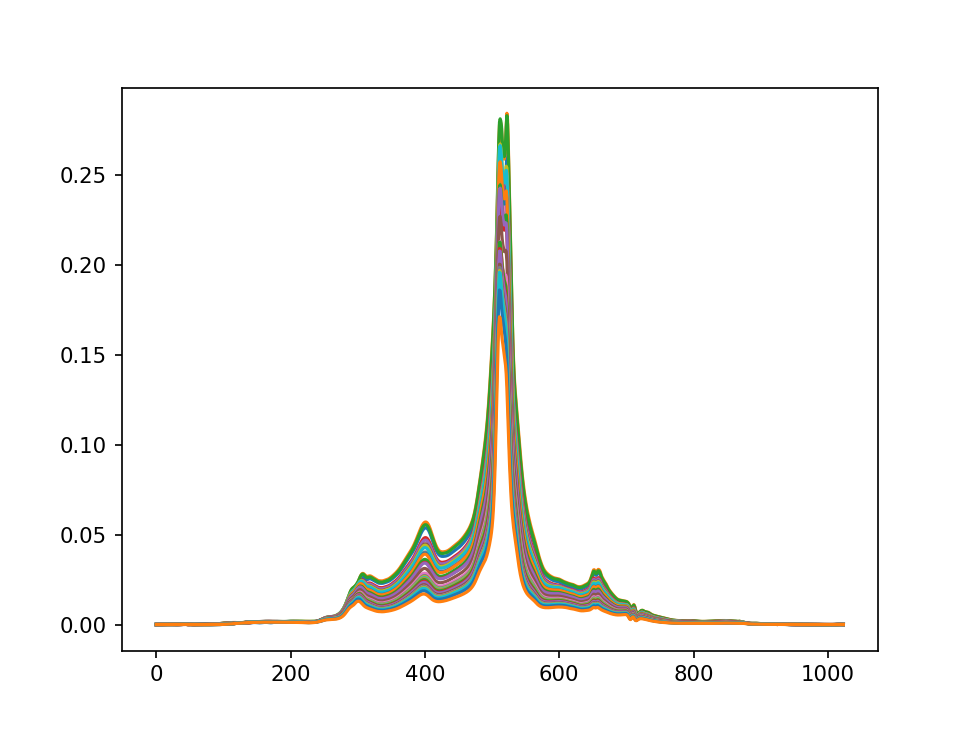

In [9]:
template_calib=(port.T*np.tile(calib,(1024,1))).T
plt.figure()
plt.plot(template_calib.T)

Now we have template in the scale of the observation and so we can subtract the observed pulse profiles from it and do the further analysis

First doing the analysis on 32 pulse integrated data.

In [10]:
ar_32p=psr.Archive_load("/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/Frequency_Appended_all_withK/Corrected_DM/32pul_Integrated/All_32p.ar")

ar_32p.set_dispersion_measure(2.64160768625521)
ar_32p.rotate_phase(ph_r-0.002)   ## It was observed that the phase is offset by 0.002 
ar_32p.dedisperse()
ar_32p.pscrunch()
ar_32p.remove_baseline()
weights=ar_32p.get_weights()
Freq_32p=ar_32p.get_frequencies()
data_32p=ar_32p.get_data()

def get_profile_residuals(data_32p):
    return np.tile(template_calib,(data_32p.shape[0],data_32p.shape[1],1,1))-data_32p

profRes_32p= get_profile_residuals(data_32p)

<IPython.core.display.Javascript object>


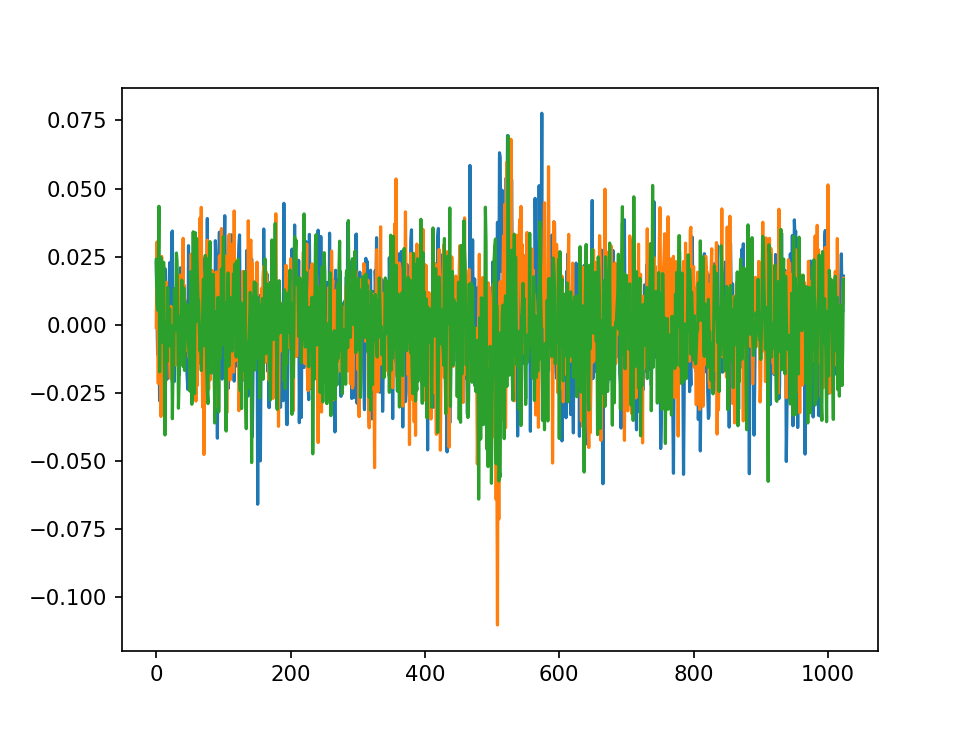

In [12]:
plt.figure()
# plt.plot(template_calib[10])
# plt.plot(data_32p[100,0,10])
plt.plot((profRes_32p[100,0,0])-(profRes_32p[100,0,15]))
plt.plot((profRes_32p[200,0,0])-(profRes_32p[200,0,15]))
plt.plot((profRes_32p[1000,0,0])-(profRes_32p[1000,0,15]))
#plt.plot((template_calib[10]-avg_prof[10])-(template_calib[11]-avg_prof[11]))

Finding the residual energies in the units of S/N according to relation
$$ S/N = \frac{\sum_{i=1}^{N_{window}} (A_{i} -B)}{\sqrt{N_{window}}\sigma_{off}}  $$

In [13]:
sqred_profRes=profRes_32p**1
Freq_32p=ar_32p.get_frequencies()
### Removingbad frequency channels#######
count=0
list_remove_chn=[]
list_keep_chn=[]

if telescope=='Parkes':
    manually_flagged=[1,3,6,20,32,39,42,49,51,52,53,54,56,57,58,59,60,61,62,63]+[2,7,8]  ## Second list contains uneven noise floor
if telescope=='MeerKAT':
    manually_flagged=[1,15,26]+[2,7,8] ## Second list contains uneven floor channels

manually_flagged.sort()

for chn in range(weights.shape[1]):
    for obs in range(weights.shape[0]):
        if (weights[obs,chn]==0):
            count += 1
    if (count > (sqred_profRes.shape[0])/2 or (chn in manually_flagged)):
        list_remove_chn.append(chn)
    else:
        list_keep_chn.append(chn)
    count=0

sqred_profRes=np.delete(sqred_profRes,list_remove_chn,axis=2)
Freq_32p=np.delete(Freq_32p,list_remove_chn)
    
def get_energies(datain,low,high):
    dim=datain.shape
    Ener_main_comp=np.ndarray([dim[0],dim[1],dim[2]])
    
    for subint in range(dim[0]):
        for pol in range(dim[1]):
            for freq in range(dim[2]):
                #mu=np.mean(datain[:,0,freq,0:100])
                #sig=np.std(datain[:,0,freq,0:100])
                Ener_main_comp[subint,pol,freq]=np.divide(np.sum(datain[subint,pol,freq,low:high]-np.mean(datain[subint,pol,freq,0:100])),np.multiply(np.sqrt(high-low),np.std(datain[subint,pol,freq,0:100])))
                #Ener_main_comp[subint,pol,freq]=np.divide(np.sum(np.abs(datain[subint,pol,freq,low:high])-np.mean(datain[subint,pol,freq,0:100])),np.multiply(np.sqrt(high-low),np.std(datain[subint,pol,freq,0:100])))
                #Ener_main_comp[subint,pol,freq]=np.divide(np.sum(datain[subint,0,freq,low:high]-mu),np.multiply(np.sqrt(high-low),sig))
    return Ener_main_comp

Energy_main_comp=get_energies(sqred_profRes,450,600)
Energy_noise=get_energies(sqred_profRes,900,940)


Calculating the covariance matrix of the residual pulse energies

<IPython.core.display.Javascript object>


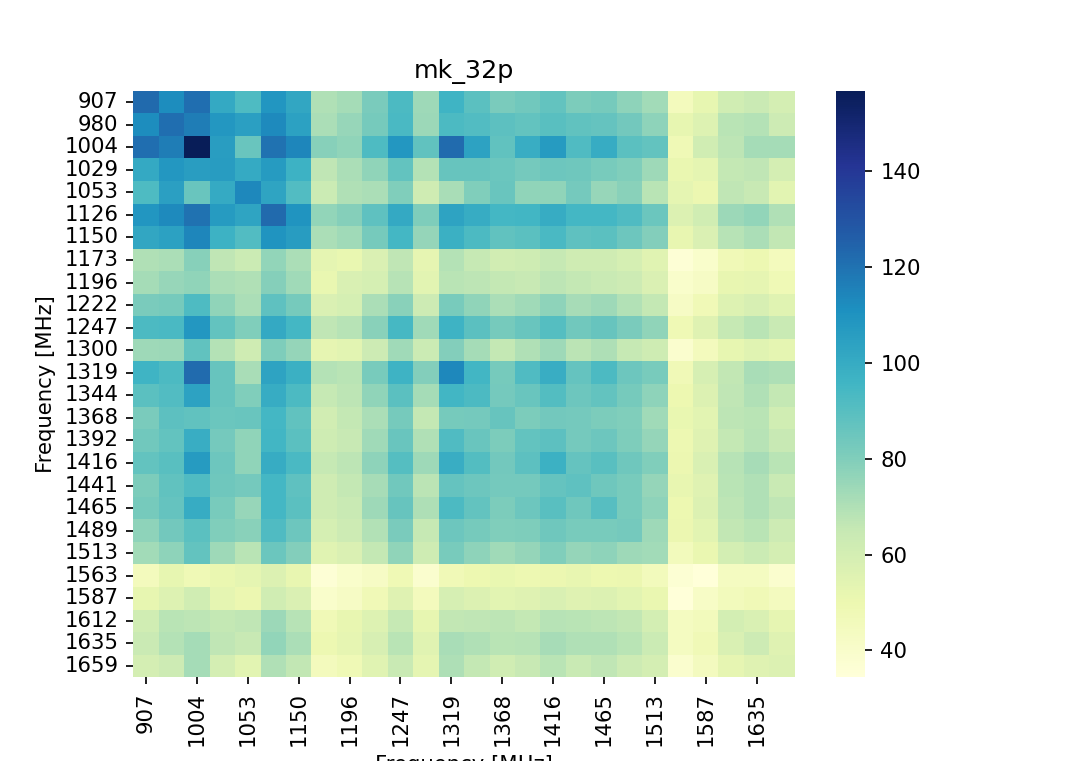

Text(0.5, 1.0, 'mk_32p')

In [14]:
Cov_profRes_32p_Entire=np.cov(Energy_main_comp[:,0,:],rowvar=False)
Cov_sysprofRes_32p_Entire=np.cov(Energy_noise[:,0,:],rowvar=False)

Cov_phjitter_32p_Entire=Cov_profRes_32p_Entire#-Cov_sysprofRes_32p_Entire
#Cov_phjitter_32p_Entire=Cov_sysprofRes_32p_Entire

df=pd.DataFrame(data=Cov_phjitter_32p_Entire,
               index=[int(Freq_32p[i]) for i in range(Freq_32p.shape[0])],
               columns=[int(Freq_32p[i]) for i in range(Freq_32p.shape[0])])
Fig, Ax = plt.subplots(figsize=(7,5))
sns.heatmap(df,ax=Ax,xticklabels=2,cmap='YlGnBu')
Ax.set_xlabel("Frequency [MHz]")
Ax.set_ylabel("Frequency [MHz]")
Ax.set_title('mk_32p')

<IPython.core.display.Javascript object>


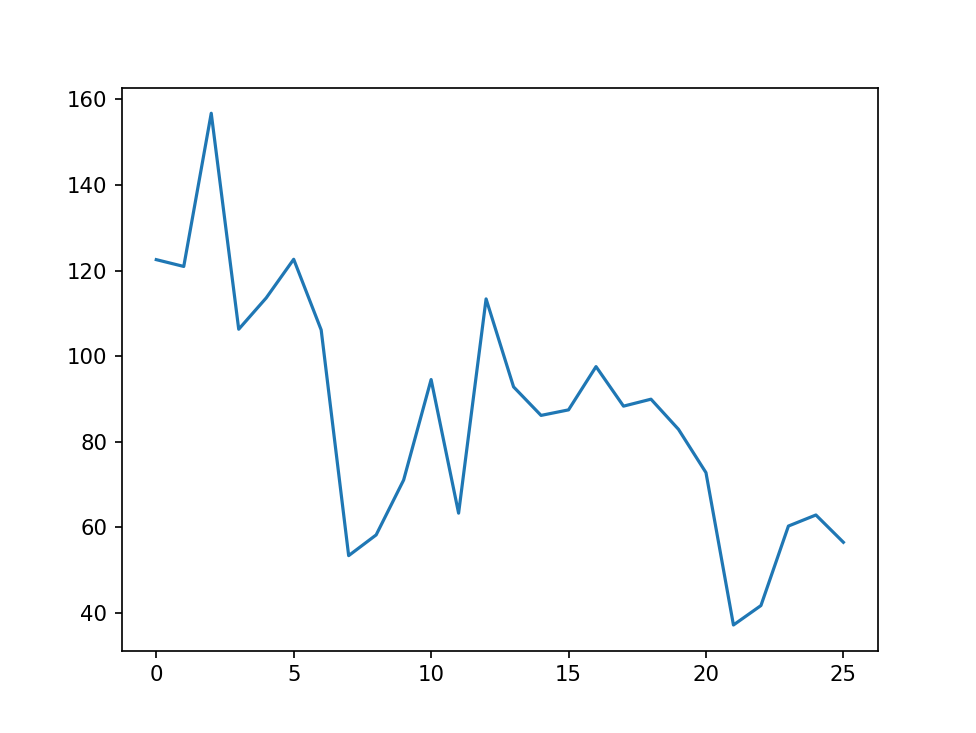

In [15]:
plt.figure()
plt.plot([Cov_phjitter_32p_Entire[chn,chn] for chn in range(Freq_32p.shape[0])])

<IPython.core.display.Javascript object>


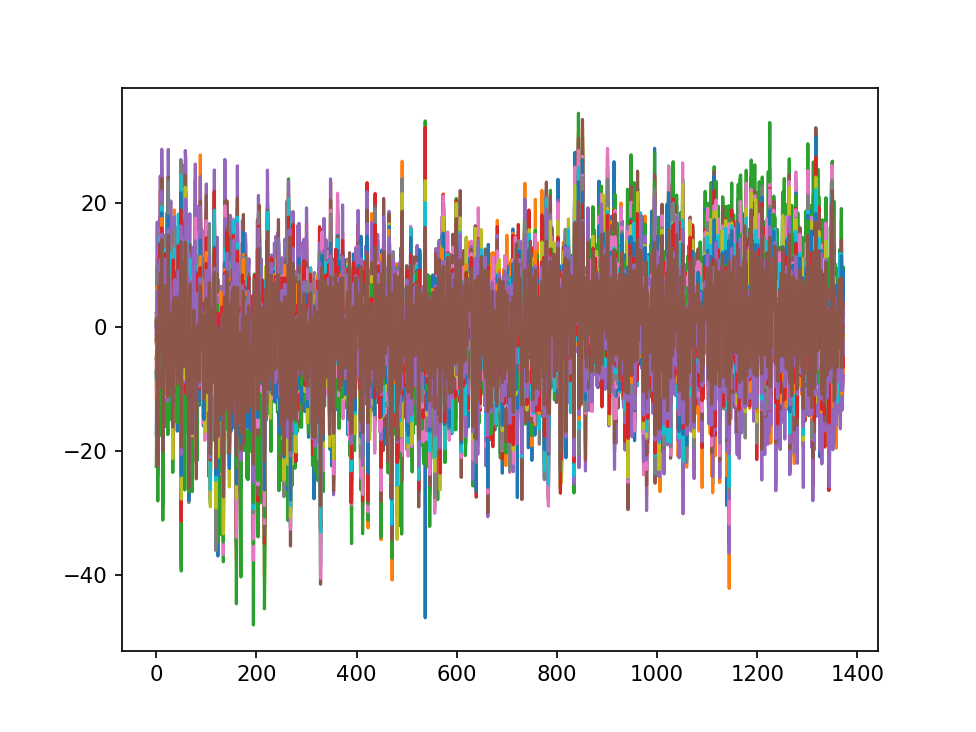

In [16]:
plt.figure()
plt.plot(Energy_main_comp[:,0,:])

<IPython.core.display.Javascript object>


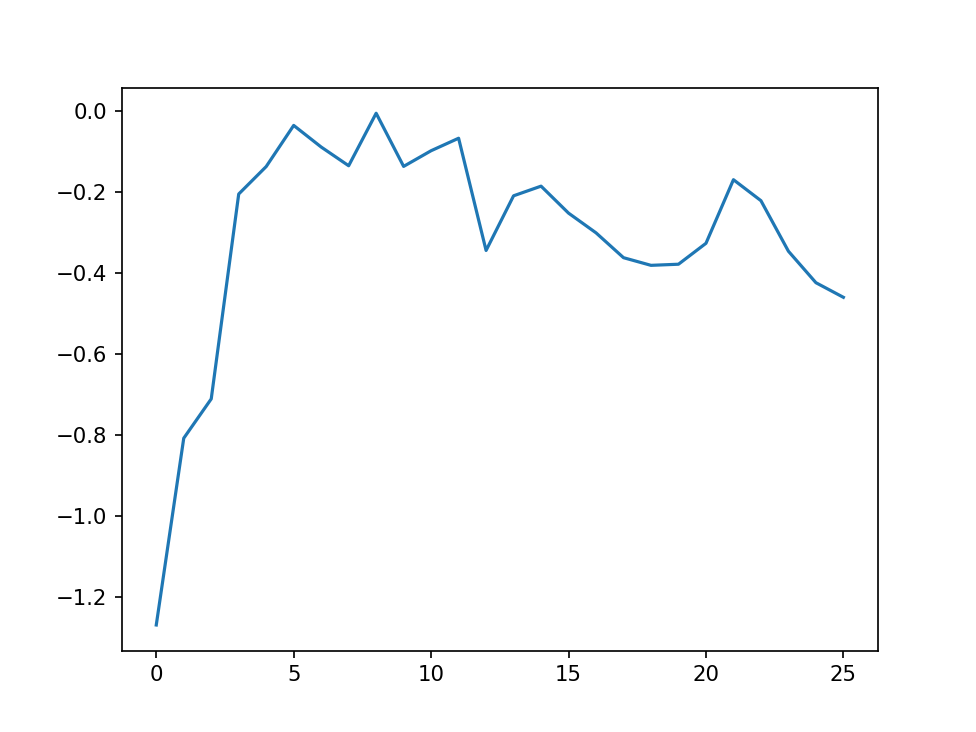

In [17]:
plt.figure()
plt.plot(np.mean(Energy_main_comp[:,0,:],axis=0))
# plt.plot(Energy_main_comp[:,0,15])
# plt.plot(Energy_main_comp[:,0,2])

<IPython.core.display.Javascript object>


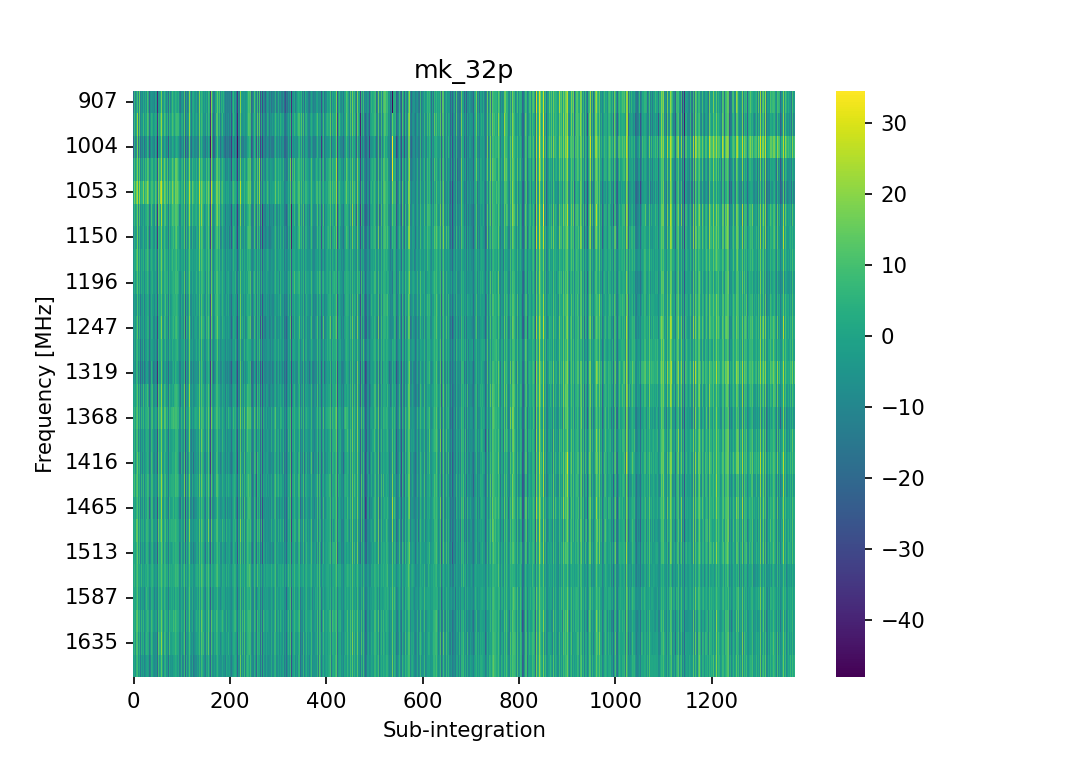

Text(0.5, 1.0, 'mk_32p')

In [18]:
df=pd.DataFrame(data=Energy_main_comp[:,0,:],
               index=(np.arange(0,Energy_main_comp.shape[0])),
               columns=[int(Freq_32p[i]) for i in range(Freq_32p.shape[0])])
Fig, Ax = plt.subplots(figsize=(7,5))
sns.heatmap(df.transpose(),ax=Ax,xticklabels=200,yticklabels=2,cmap='viridis')
Ax.set_xlabel("Sub-integration")
Ax.set_ylabel("Frequency [MHz]")
Ax.set_title('mk_32p')

In [19]:
def fit_parabola(x,a,b):
    return a*x**2 + b

def fit_offset_parabola(x,a,b,off):
    return a*(x-off)**2 + b

<IPython.core.display.Javascript object>


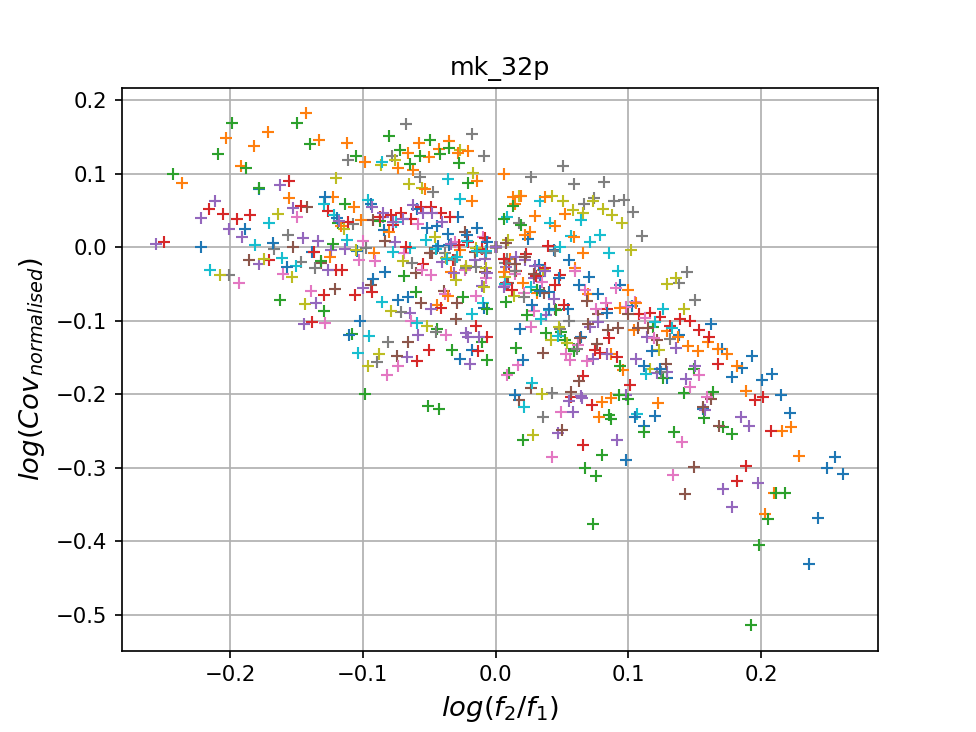

In [20]:
plt.figure()
for chn in np.arange(0,25):#10*sbplt,10*(sbplt+1)):#R_32p_Entire_spr.shape[0]):

    freq_axis=[]
    corr_axis=[]
    for i in range(Freq_32p.shape[0]):
        freq_axis.append((np.log10(Freq_32p[i]/Freq_32p[chn])**1))
        corr_axis.append(np.log10(Cov_phjitter_32p_Entire[i,chn]/Cov_phjitter_32p_Entire[chn,chn])**1)
    plt.plot((freq_axis),corr_axis,'+')#,label="$f_{1}=$"+str(int(Freq_32p_Entire[chn])))
plt.title("mk_32p")
plt.ylabel("$log(Cov_{normalised})$",size=13)
plt.xlabel("$log(f_{2}/f_{1})$",size=13)
#plt.plot(np.linspace(-0.6,0.6,num=50),fit_parabola(np.linspace(-0.6,0.6,num=50),-2.03,-0.03),'purple',linewidth=2) ## Parkes
#plt.plot(np.linspace(-0.25,0.25,num=50),fit_parabola(np.linspace(-0.25,0.25,num=50)+0.04,-2.66,-0.00),'purple',linewidth=2)  ##MeerKAT

plt.grid()
#plt.legend()

#### Finding covariance matrix for each residual profile

Checking covarince of the residual profiles across the frequency axis.
In this analysis we find the coaviance of residual profiles for each observation and then take the mean of all observations.

In [21]:
Cov_freq_profRes_32p_Entire=np.empty([sqred_profRes.shape[0],sqred_profRes.shape[2],sqred_profRes.shape[2]])

for obs in range(sqred_profRes.shape[0]):
    Cov_freq_profRes_32p_Entire[obs]=np.cov(sqred_profRes[obs,0,:,:],rowvar=True)
    
sysnoise=np.zeros((sqred_profRes.shape[2],sqred_profRes.shape[2]))    
np.fill_diagonal(sysnoise,np.std(sqred_profRes[:,0,:,0:100],axis=0))

<IPython.core.display.Javascript object>


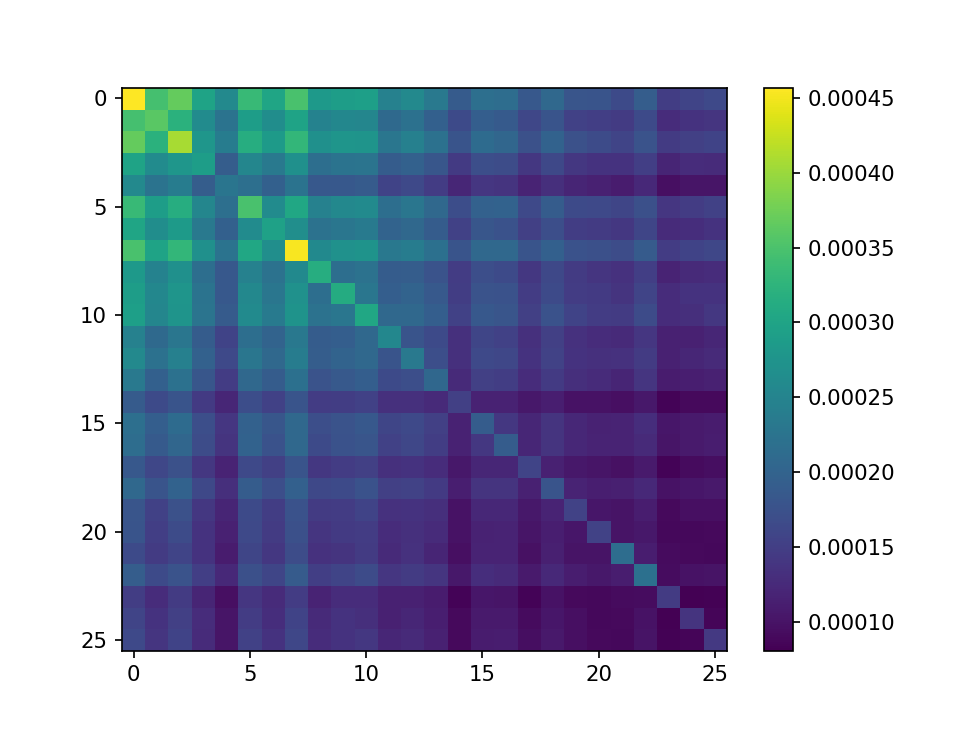

In [22]:
plt.figure()
plt.imshow((Cov_freq_profRes_32p_Entire[50]),aspect='auto')
plt.colorbar()

<IPython.core.display.Javascript object>


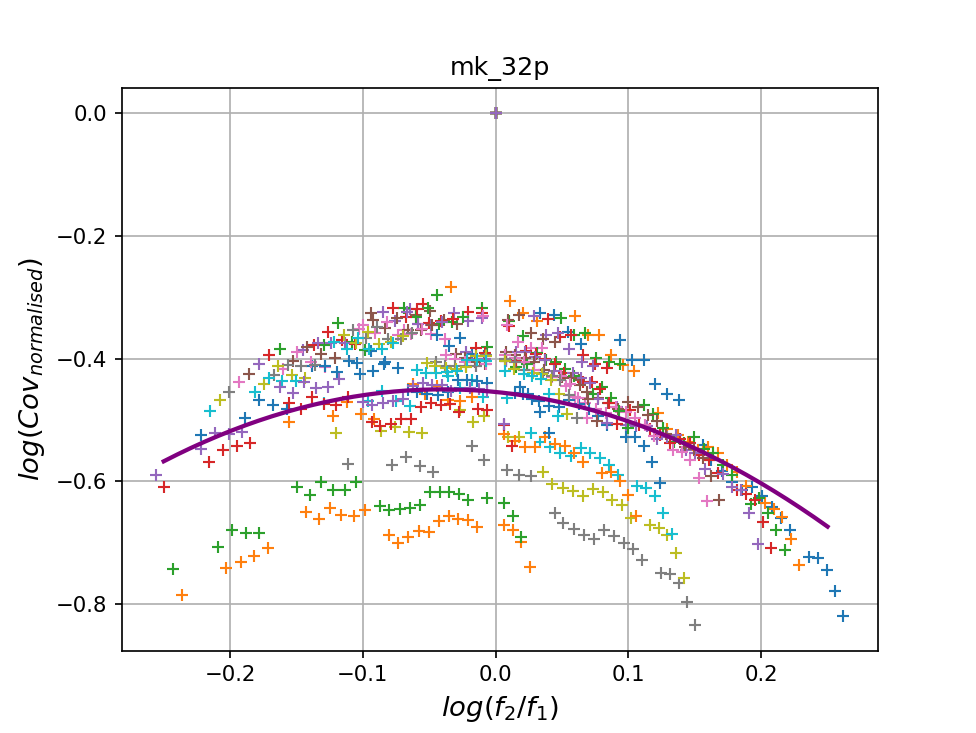

In [24]:
Cov_freq_profRes_32p_Entire_avg=np.mean(Cov_freq_profRes_32p_Entire,axis=0)#-sysnoise
plt.figure()
for chn in np.arange(0,25):#10*sbplt,10*(sbplt+1)):#R_32p_Entire_spr.shape[0]):
    freq_axis=[]
    corr_axis=[]
    for i in range(Freq_32p.shape[0]):
        freq_axis.append((np.log10(Freq_32p[i]/Freq_32p[chn])**1))
        corr_axis.append(np.log10(Cov_freq_profRes_32p_Entire_avg[i,chn]/Cov_freq_profRes_32p_Entire_avg[chn,chn])**1)
        #corr_axis.append(np.log10(Cov_freq_profRes_32p_Entire_avg[i,chn]))
plt.plot((freq_axis),corr_axis,'+')#,label="$f_{1}=$"+str(int(Freq_32p_Entire[chn])))
plt.title("mk_32p")
plt.ylabel("$log(Cov_{normalised})$",size=13)
plt.xlabel("$log(f_{2}/f_{1})$",size=13)
#plt.plot(np.linspace(-0.6,0.6,num=50),fit_parabola(np.linspace(-0.6,0.6,num=50),-2.03,-0.03),'purple',linewidth=2) ## Parkes
plt.plot(np.linspace(-0.25,0.25,num=50),fit_parabola(np.linspace(-0.25,0.25,num=50)+0.04,-2.66,-0.00)-0.45,'purple',linewidth=2)  ##MeerKAT
plt.grid()
#plt.legend()